### Data Loading and Cleaning

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
df = pd.read_csv('data.csv')
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (2051, 11)


,PAYS,Code,Ville,X,Y,Date,End_of_sampling,Duration(h.min),I_131_(Bq/m3),Cs_134_(Bq/m3),Cs_137_(Bq/m3)
0,SE,1,RISOE,12.07,55.7,86/04/27,24:00:00,24.0,1,0,0.24
1,SE,1,RISOE,12.07,55.7,86/04/28,24:00:00,24.0,0.0046,0.00054,0.00098
2,SE,1,RISOE,12.07,55.7,86/04/29,12:00,12.0,0.0147,0.0043,0.0074
3,SE,1,RISOE,12.07,55.7,86/04/29,24:00:00,12.0,0.00061,0,0.00009
4,SE,1,RISOE,12.07,55.7,86/04/30,24:00:00,24.0,0.00075,0.0001,0.00028


In [6]:
def clean_radionuclide(val):
    s = str(val).strip().upper()

    if s in ['L', 'N', '?']:
        return np.nan

    try:
        return float(s)
    except ValueError:
        return np.nan

def clean_duration(val):
    if pd.isna(val) or val == 99.99: # 99.99 an error code in data
        return np.nan

    hours = int(val)
    minutes = round((val - hours) * 100)

    if minutes < 60:
        return hours + (minutes / 60.0)
    else:
        return val

In [7]:
target_cols = ['I_131_(Bq/m3)', 'Cs_134_(Bq/m3)', 'Cs_137_(Bq/m3)']

for col in target_cols:
    clean_col_name = f"Clean_{col.split('_')[0]}_{col.split('_')[1]}"
    df[clean_col_name] = df[col].apply(clean_radionuclide)

In [8]:
df['Date_Obj'] = pd.to_datetime(df['Date'], format='%y/%m/%d')
df['Date_Str'] = df['Date_Obj'].dt.strftime('%Y-%m-%d')
df['Duration_Hours'] = df['Duration(h.min)'].apply(clean_duration)


In [9]:
print("Data Cleaning Complete.")
print(df[['Date_Str', 'Clean_I_131', 'Clean_Cs_137']].info())
df.head()

Data Cleaning Complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date_Str      2051 non-null   object 
 1   Clean_I_131   2009 non-null   float64
 2   Clean_Cs_137  1506 non-null   float64
dtypes: float64(2), object(1)
memory usage: 48.2+ KB
None


,PAYS,Code,Ville,X,Y,Date,End_of_sampling,Duration(h.min),I_131_(Bq/m3),Cs_134_(Bq/m3),Cs_137_(Bq/m3),Clean_I_131,Clean_Cs_134,Clean_Cs_137,Date_Obj,Date_Str,Duration_Hours
0,SE,1,RISOE,12.07,55.7,86/04/27,24:00:00,24.0,1,0,0.24,1.00000,0.00000,0.24000,1986-04-27,1986-04-27,24.0
1,SE,1,RISOE,12.07,55.7,86/04/28,24:00:00,24.0,0.0046,0.00054,0.00098,0.00460,0.00054,0.00098,1986-04-28,1986-04-28,24.0
2,SE,1,RISOE,12.07,55.7,86/04/29,12:00,12.0,0.0147,0.0043,0.0074,0.01470,0.00430,0.00740,1986-04-29,1986-04-29,12.0
3,SE,1,RISOE,12.07,55.7,86/04/29,24:00:00,12.0,0.00061,0,0.00009,0.00061,0.00000,0.00009,1986-04-29,1986-04-29,12.0
4,SE,1,RISOE,12.07,55.7,86/04/30,24:00:00,24.0,0.00075,0.0001,0.00028,0.00075,0.00010,0.00028,1986-04-30,1986-04-30,24.0


### Exploratory Data Analysis (EDA)

In [19]:
# 1. Create a Summary Table by Country (PAYS)
# We aggregate the I-131 data to find the Max, Mean, Sum, and Count for each country
country_stats = df.groupby('PAYS')['Clean_I_131'].agg(['max', 'sum', 'mean', 'count']).reset_index()

# 2. Sort by Maximum Concentration (Severity)
# This identifies where the "Hotspots" were
top_severity = country_stats.sort_values(by='max', ascending=False)

print("--- Top 5 Countries by Peak Contamination (Acute Risk) ---")
print(top_severity[['PAYS', 'max', 'count']].head(5))
print("\n")

# 3. Sort by Total Cumulative Load
# This identifies where the plume lingered or washed out (rain)
top_burden = country_stats.sort_values(by='sum', ascending=False)

print("--- Top 5 Countries by Total Integrated Concentration (Cumulative Risk) ---")
print(top_burden[['PAYS', 'sum', 'count']].head(5))
print("\n")

# 4. Identify the "First Responders" (Plume Arrival Time)
# We find the earliest date a country reported a significant value (> 0.1 Bq/m3)
early_detection = df[df['Clean_I_131'] > 0.1].groupby('PAYS')['Date_Obj'].min().sort_values()

print("--- Plume Arrival Timeline (First 5 Countries to detect > 0.1 Bq/m3) ---")
print(early_detection.head(5))

--- Top 5 Countries by Peak Contamination (Acute Risk) ---
   PAYS    max  count
3    CZ  70.00    133
0    AU  58.09    223
7    FI  31.00    107
11   IT  24.95    302
4    DE  21.00    245


--- Top 5 Countries by Total Integrated Concentration (Cumulative Risk) ---
   PAYS          sum  count
0    AU  1038.629351    223
11   IT   917.743000    302
3    CZ   531.960100    133
4    DE   253.325900    245
7    FI   160.513940    107


--- Plume Arrival Timeline (First 5 Countries to detect > 0.1 Bq/m3) ---
PAYS
SE   1986-04-27
FI   1986-04-28
NO   1986-04-28
AU   1986-04-29
DE   1986-04-29
Name: Date_Obj, dtype: datetime64[ns]


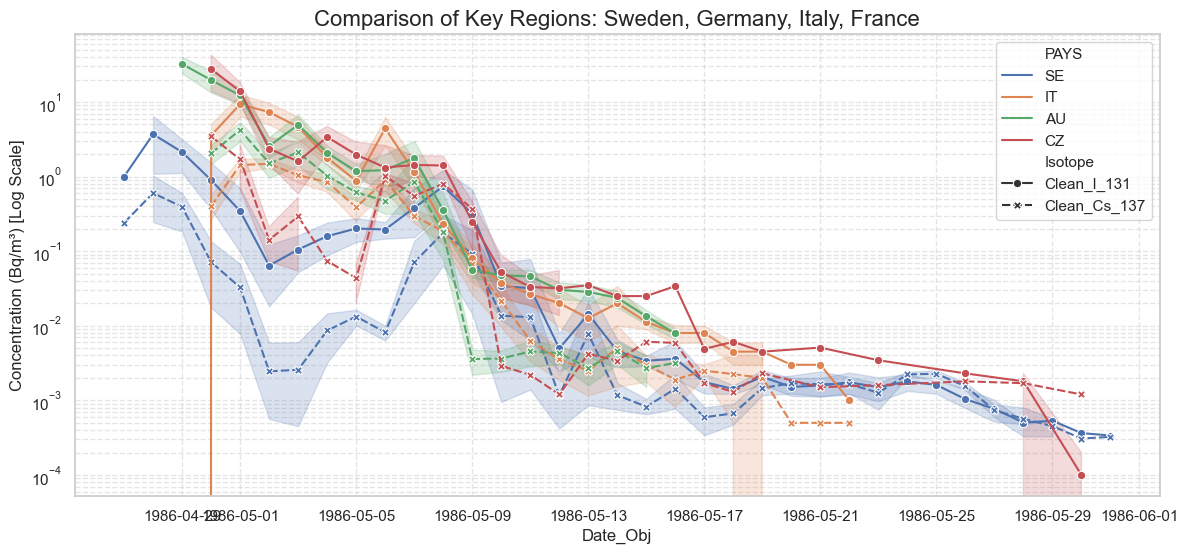

In [20]:
df_melted = df.melt(id_vars=['Date_Obj', 'PAYS'],
                    value_vars=['Clean_I_131', 'Clean_Cs_137'],
                    var_name='Isotope', value_name='Concentration')

target_countries = ['SE', 'CZ', 'AU', 'IT']
subset_df = df_melted[df_melted['PAYS'].isin(target_countries)]
subset_df = subset_df[subset_df['Date_Obj'] <= '1986-06-15']

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=subset_df,
    x='Date_Obj',
    y='Concentration',
    hue='PAYS',
    style='Isotope',
    markers=True,
    dashes=True
)
plt.yscale('log')
plt.title('Comparison of Key Regions: Sweden, Germany, Italy, France', fontsize=16)
plt.ylabel('Concentration (Bq/m³) [Log Scale]')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

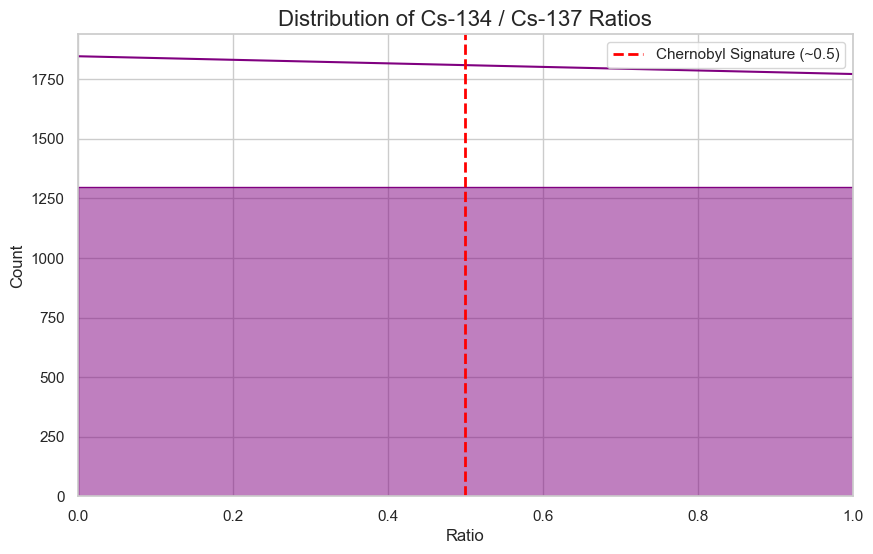

Mean Isotopic Ratio: 1.403


In [11]:
df['Cs_Ratio'] = df['Clean_Cs_134'] / df['Clean_Cs_137']
# Filter for valid ratios (remove NaNs and Infs)
valid_ratios = df['Cs_Ratio'][np.isfinite(df['Cs_Ratio'])]

plt.figure(figsize=(10, 6))
sns.histplot(valid_ratios, bins=30, kde=True, color='purple', element="step")
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Chernobyl Signature (~0.5)')
plt.title('Distribution of Cs-134 / Cs-137 Ratios', fontsize=16)
plt.xlabel('Ratio')
plt.xlim(0, 1.0) # Focus on the relevant range
plt.legend()
plt.show()

print(f"Mean Isotopic Ratio: {valid_ratios.mean():.3f}")

In [16]:
import plotly.express as px
import numpy as np

# 1. Prepare Data
# Sort by date for correct animation order
df_map = df.sort_values(by='Date_Obj').copy()

# --- THE FIX ---
# Create a dedicated column for 'size' where NaNs are replaced with 0.
# This prevents the "Invalid element" error. 0 means the bubble just won't be drawn.
df_map['Size_I131'] = df_map['Clean_I_131'].fillna(0)

# Calculate Log values for 'color' (handling NaNs by filling with a tiny number)
df_map['Log_I131'] = np.log10(df_map['Clean_I_131'].fillna(0.001) + 0.001)
df_map['Log_I131'] = df_map['Log_I131'].clip(lower=-2)

# 2. Generate Animation
fig = px.scatter_geo(
    df_map,
    lon='X',
    lat='Y',
    size='Size_I131',          # USE THE FIXED ZERO-FILLED COLUMN HERE
    color='Log_I131',          # Color uses the Log scale
    hover_name='Ville',
    # We display the *original* 'Clean_I_131' in the hover tooltip so you see the real value (or NaN)
    hover_data={'Size_I131': False, 'Clean_I_131': ':.2f', 'Log_I131': False, 'X': False, 'Y': False},
    animation_frame='Date_Str',
    projection="natural earth",
    title='Spread of Iodine-131 Across Europe (April-May 1986)',
    color_continuous_scale=px.colors.sequential.Magma_r,
    size_max=60,               # Adjust to make bubbles larger/smaller
    range_color=[-2, 2]        # Fixed color range
)

# 3. Focus Map on Europe
fig.update_geos(
    center=dict(lon=15, lat=50),
    lataxis_range=[35, 70],
    lonaxis_range=[-10, 35],
    showcountries=True, countrycolor="Black",
    showland=True, landcolor="#f0f0f0"
)

# 4. Set Animation Speed
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 800

fig.show()

### Biological Dose Assessment
#### BIOKINETIC MODELING

In [23]:
# Define Biological Constants
biokinetics = {
    'Adult': {
        'Breathing_Rate_m3h': 0.92,       # ~22.2 m3/day
        'I131_Dose_Coeff_SvBq': 7.4e-9,   # Risk per Becquerel (Iodine)
        'Cs137_Dose_Coeff_SvBq': 4.6e-9   # Risk per Becquerel (Cesium)
    },
    'Infant_1y': {
        'Breathing_Rate_m3h': 0.22,       # ~5.4 m3/day (Much less air!)
        'I131_Dose_Coeff_SvBq': 7.2e-8,   # ~10x MORE SENSITIVE per Bq
        'Cs137_Dose_Coeff_SvBq': 5.4e-9   # Slightly more sensitive
    }
}

dose_df = df.copy()

dose_df['Duration_Model'] = dose_df['Duration_Hours'].fillna(24)
dose_df['Duration_Model'] = dose_df['Duration_Model'].replace(0, 24)



In [24]:
def calculate_dose(row, age_group):
    params = biokinetics[age_group]

    # --- IODINE-131 DOSE ---
    # Intake (Bq) = Concentration (Bq/m3) * Breathing Rate (m3/h) * Time (h)
    conc_i = row['Clean_I_131'] if pd.notnull(row['Clean_I_131']) else 0
    intake_i = conc_i * params['Breathing_Rate_m3h'] * row['Duration_Model']

    # Dose (Sv) = Intake (Bq) * Coefficient (Sv/Bq)
    dose_i = intake_i * params['I131_Dose_Coeff_SvBq']

    # --- CESIUM-137 DOSE ---
    conc_cs = row['Clean_Cs_137'] if pd.notnull(row['Clean_Cs_137']) else 0
    intake_cs = conc_cs * params['Breathing_Rate_m3h'] * row['Duration_Model']
    dose_cs = intake_cs * params['Cs137_Dose_Coeff_SvBq']

    return dose_i, dose_cs

# Calculate for Adult
dose_df[['Adult_Dose_I131', 'Adult_Dose_Cs137']] = dose_df.apply(
    lambda row: pd.Series(calculate_dose(row, 'Adult')), axis=1
)

# Calculate for Infant
dose_df[['Infant_Dose_I131', 'Infant_Dose_Cs137']] = dose_df.apply(
    lambda row: pd.Series(calculate_dose(row, 'Infant_1y')), axis=1
)

# Convert Sieverts to microSieverts (µSv) for readability (1 Sv = 1,000,000 µSv)
cols_to_convert = ['Adult_Dose_I131', 'Adult_Dose_Cs137', 'Infant_Dose_I131', 'Infant_Dose_Cs137']
for col in cols_to_convert:
    dose_df[col] = dose_df[col] * 1e6

# 5. Results Aggregation (Cumulative Dose per Country)
total_risk = dose_df.groupby('PAYS')[cols_to_convert].sum().reset_index()

# Add a "Risk Ratio" column (How much worse is it for infants?)
total_risk['Pediatric_Risk_Factor'] = total_risk['Infant_Dose_I131'] / total_risk['Adult_Dose_I131']

print("--- CUMULATIVE INHALATION DOSE (µSv) ---")
print(total_risk)

--- CUMULATIVE INHALATION DOSE (µSv) ---
   PAYS  Adult_Dose_I131  Adult_Dose_Cs137  Infant_Dose_I131  \
0    AU        26.573110          4.587291         61.826979   
1    BE         2.972789          0.703647          6.916712   
2    CH         4.205797          0.673688          9.785520   
3    CZ        57.896547          1.106424        134.706419   
4    DE        27.958913         10.534452         65.051290   
5    ES         0.000000          0.058513          0.000000   
6     F        17.323023          3.882657         40.305036   
7    FI         2.082507          1.172008          4.845315   
8    GR        13.971650          2.548341         32.507482   
9    HU         2.755688          0.570716          6.411588   
10   IR         0.000000          0.000000          0.000000   
11   IT        19.541979          3.622750         45.467824   
12   NL         2.867599          1.133306          6.671970   
13   NO         3.978927          1.047345          9.257669   